<a href="https://colab.research.google.com/github/lingsv/wids_collaborative_workshop/blob/main/deteccao_intencao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <b>Detecção de intenções</b>
#### Para este tutorial, foi utilizado a base de dados <b>SNIPS</b> para a detecção de intenções utilizando o modelo pré-treinado word2vec e KNN

#### O que é SNIPS?

> É uma tradicional base de dados em inglês, utilizada para avaliação dos modelos NLP para a tarefa de detecção de intenções. Logo, possui frases que expressam pedidos como "Toque a música x" ou "Qual a previsão do tempo em 10 de junho?" e suas respectivas intenções como "TocarMusica" e "ObterPrevisãoTempo". Como interpretar a tarefa de detectar intenções como uma classificação de texto. 



#### Quais as etapas?
1. Vizualizar dataset de treino e teste
2. Extrair os vetores de palavras (words) com o Word2vec
3. Alimentar o classificador com esses vetores e Treinar o Classificador KNN
4. Avaliar o Desempenho do classificador com Acurácia e Matriz de confusão

In [1]:
#imposts
import pandas as pd
import string
import gensim
import numpy as np
import gensim.downloader 



### 1.  Vizualizar dataset de Treino e Teste

In [3]:
# Obtendo a base de treinamento

!git clone https://github.com/ZephyrChenzf/SF-ID-Network-For-NLU.git

fatal: destination path 'SF-ID-Network-For-NLU' already exists and is not an empty directory.


In [4]:
# obter base de treinamento
x_treino =pd.read_csv("SF-ID-Network-For-NLU/data/snips/train/seq.in")
y_treino =pd.read_csv("SF-ID-Network-For-NLU/data/snips/train/label")

# --------- Passando os dados para dataframe -----------------------------------
dataset_treino = pd.DataFrame(pd.concat([x_treino,y_treino],axis=1))
dataset_treino.columns=['sentences','intent']
dataset_treino.head()

,sentences,intent
0,add step to me to the 50 clásicos playlist,AddToPlaylist
1,i give this current textbook a rating value of...,RateBook
2,play the song little robin redbreast,PlayMusic
3,please add iris dement to my playlist this is ...,AddToPlaylist
4,add slimm cutta calhoun to my this is prince p...,AddToPlaylist


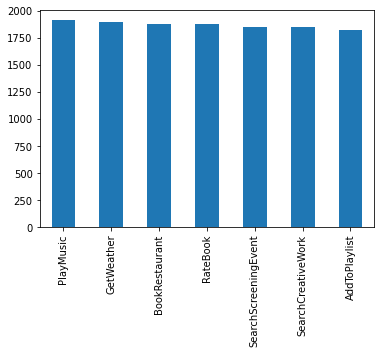

In [5]:
dataset_treino['intent'].value_counts().plot(kind = 'bar')

In [6]:
dataset_treino['intent'].value_counts()

PlayMusic               1913
GetWeather              1896
BookRestaurant          1881
RateBook                1876
SearchScreeningEvent    1852
SearchCreativeWork      1847
AddToPlaylist           1818
Name: intent, dtype: int64

In [7]:
dataset_treino.describe()

,sentences,intent
count,13083,13083
unique,12894,7
top,find the movie schedule,PlayMusic
freq,9,1913


In [8]:

x_teste =pd.read_csv("SF-ID-Network-For-NLU/data/snips/test/seq.in")
y_teste =pd.read_csv("SF-ID-Network-For-NLU/data/snips/test/label")

# --------- Passando os dados para dataframe -----------------------------------

dataset_teste = pd.DataFrame(pd.concat([x_teste,y_teste],axis=1))
dataset_teste.columns=['sentences','intent']
# Viazualizando a tabela
dataset_teste.head()


,sentences,intent
0,i want to bring four people to a place that s ...,BookRestaurant
1,put lindsey cardinale into my hillary clinton ...,AddToPlaylist
2,will it snow in mt on june 13 2038,GetWeather
3,play signe anderson chant music that is newest,PlayMusic
4,can you let me know what animated movies are p...,SearchScreeningEvent


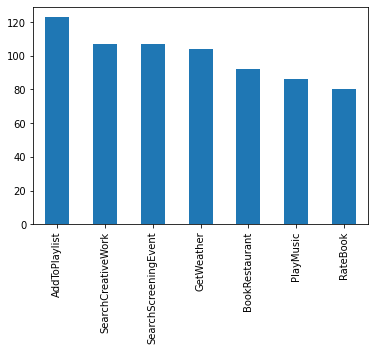

In [9]:
dataset_teste['intent'].value_counts().plot(kind = 'bar')

In [10]:
dataset_teste['intent'].value_counts()

AddToPlaylist           123
SearchCreativeWork      107
SearchScreeningEvent    107
GetWeather              104
BookRestaurant           92
PlayMusic                86
RateBook                 80
Name: intent, dtype: int64

In [11]:
dataset_teste.describe()

,sentences,intent
count,699,699
unique,698,7
top,find movie times,AddToPlaylist
freq,2,123


### 2. Extrair os vetores de palavras (words) com o Word2vec








### <b>Quem é Word2vec?</b>
> O Word2vec é um dos algoritmos classificos de NLP que fazem a conversão de palavras em um vetor númerico (como na abstração dos vetores vista no workshop). Está técnica é composta por uam rede neural e pode ser operada em duas abordagens ( conforme a imagem a baixo).

* <b>Abordagem CBOW:</b>
> Durante o treinamento a rede deve prever a palavra do meio da frase. Por exemplo se tenho a frase <b>ELA ASSISTIU ___  NA SEGUNDA-FEIRA</b>, o espaço em branco deve ser preenchido com a palavra <b>AULA</b>

* <b> Abordagem Skip-Gram:</b>
> Está abordagem de treinamento fornece apenas uma palavra e a rede apresentar as palavras ao redor. Por exemplo, forneço a rede a palavra <b>AULA</b>, o modelo deve retornar palavras vizinhas como <b>ELA</b>, <b>ASSISTE</b>, <b>NA SEGUNDA - FEIRA</b> ou palavras similares que dão sentido a palavra fornecida "AULA". Veja que, treinamento a rede neural por muitas iterações e com muitos dados, os pesos destas redes acabarão gerando os vetores representativos de cada palavra o vocabulário.

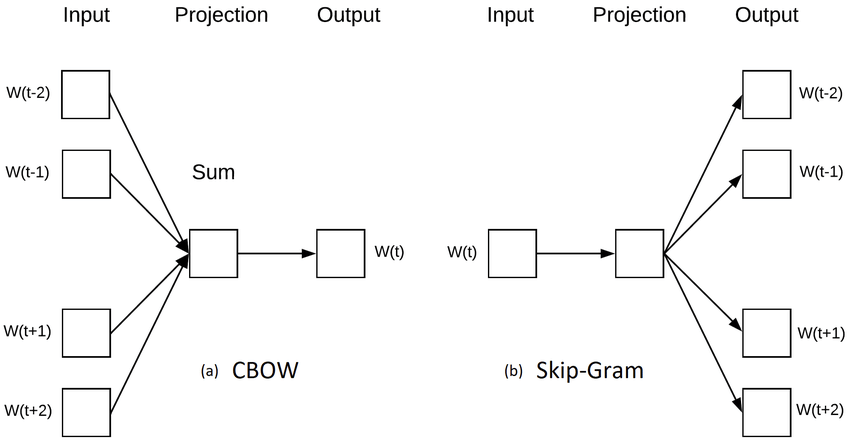

### Para mais edtalhes do Word2vec
> [Artigo públicado pelos autores](https://arxiv.org/pdf/1301.3781.pdf)

> [Explicação mais detalhada em português ](https://medium.com/@everton.tomalok/word2vec-e-sua-import%C3%A2ncia-na-etapa-de-pr%C3%A9-processamento-d0813acfc8ab)

#### Para o tutorial de hoje, usaremos um modelo <b>Pré-treinado</b> ou seja, modelo do word2vec já treinado com muitos dados em inglês. Iremos fazer o carregamento do modelo pelo framework <b>Gensim</b>.

> Neste [link](https://radimrehurek.com/gensim/models/word2vec.html) possui mais informações do Gensim

> [Link Word2vec google](https://code.google.com/archive/p/word2vec/)

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!gzip -d  /content/drive/MyDrive/wids2021/GoogleNews-vectors-negative300.bin.gz

In [15]:
from gensim.models import KeyedVectors

word2vec_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/wids2021/GoogleNews-vectors-negative300.bin', binary=True)


In [16]:
# Fazendo alguns testes no modelo
print('Vetor da palavra Home: ', word2vec_model['home'])
print('----------------------------')
print('Tamanho do vetor: ', len(word2vec_model['home']))

Vetor da palavra Home:  [-0.01184082  0.07958984  0.0168457  -0.08984375  0.08642578  0.02416992
  0.0255127  -0.18945312  0.14160156  0.08447266  0.16992188 -0.25
 -0.0534668  -0.02832031  0.04541016 -0.14746094  0.01226807  0.05639648
  0.01953125  0.21582031  0.15722656 -0.15917969  0.08837891 -0.10595703
 -0.00408936 -0.02331543 -0.04931641  0.08154297  0.03808594  0.00177002
  0.05517578  0.03735352 -0.14648438 -0.03808594 -0.05517578  0.01135254
 -0.07861328 -0.14941406  0.09033203  0.03710938  0.08837891 -0.01483154
  0.18261719  0.09667969 -0.05517578  0.16308594  0.03955078  0.1640625
  0.08398438  0.0279541  -0.03442383  0.296875    0.140625    0.09863281
 -0.18457031 -0.26367188 -0.12109375  0.18261719  0.02282715 -0.04248047
 -0.02062988  0.08251953 -0.00140381  0.02246094 -0.07617188  0.02709961
 -0.04711914  0.05639648 -0.00250244  0.11328125  0.12890625 -0.09667969
  0.06738281 -0.08154297 -0.10546875  0.06982422 -0.02294922  0.00622559
  0.01843262 -0.02612305  0.057861

In [18]:
#Função para obter os vetores de palavras

def word2vec_extract(words, word2vec_model):
    """extract features model word2vec.
    """
    vector = []
    # A cada sentença é quebrada em um vetor de palavras.
    for word in words.split(' '):
        word = word.lower()
        if word in word2vec_model:
            vector.append(word2vec_model[word])
    if len(vector) != 0:
        vector = np.mean(vector, axis=0)
    else:
        vector = np.zeros(vec.vector_size)

    return vector

# Metodo que obtêm  os vetores de cada asbstract
def get_vectors(dataset, word2vec):
    vector= []
    for index, row in dataset.iterrows():
        vector.append(word2vec_extract(row['sentences'],word2vec))
    return vector



In [20]:
# Converter as frases em vetores 
dataset_train_vectors = get_vectors(dataset_treino, word2vec_model)
dataset_test_vectors = get_vectors(dataset_teste, word2vec_model)


dataset_test_vectors[1]

array([-0.03299459,  0.10653687,  0.04422824,  0.1369222 , -0.04697164,
       -0.13961792, -0.02195231, -0.10219955,  0.04912313, -0.0018514 ,
       -0.09316   , -0.04997762, -0.03566106,  0.03081512, -0.02464803,
        0.12042236,  0.10108439,  0.04998779, -0.00024668, -0.08787028,
       -0.05832927,  0.04542796,  0.01030731, -0.0567627 , -0.06268946,
        0.03555298, -0.08194479,  0.10294899, -0.02397919, -0.02167765,
        0.05273819,  0.10069784, -0.11815643,  0.05670166, -0.02207216,
        0.00721232, -0.04986318,  0.05230204,  0.0175883 ,  0.15233867,
       -0.01808548, -0.08032227,  0.16615804,  0.0463562 ,  0.0190684 ,
        0.03655751,  0.03188578, -0.03640747,  0.02052816,  0.05949402,
       -0.01299032,  0.01998901,  0.04066531,  0.04409282, -0.03497823,
        0.01015727, -0.06531525, -0.02740049,  0.01438904, -0.08055115,
        0.03335571,  0.02794901, -0.02799479, -0.04312134, -0.01696777,
       -0.10269419,  0.01080322, -0.01164754, -0.0016276 ,  0.05

### 3. Alimentar o classificador com esses vetores e Treinar o Classificador 
#### O classificador tem com objetivo aprender a diferenciar classes de exemplos, no nosso caso deve aprender a diferenciar as intenções.
#### Para isso iremos usar o KNN como classificador.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
Knn = KNeighborsClassifier(n_neighbors=3)

# Treinando o modelo com a nossos vetores dos abstract da base de treino

Knn.fit(dataset_train_vectors, dataset_treino['intent'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [22]:
# Obtendo as predições com a base de teste, 
#com essas predições consiguiremos avaliar se nosso modelo aprendeu a diferenciar os abstracts

classes_preditas = Knn.predict(dataset_test_vectors)


In [23]:
#mostrar as 10 primeiras
classes_preditas[:10]

array(['BookRestaurant', 'AddToPlaylist', 'GetWeather', 'PlayMusic',
       'SearchScreeningEvent', 'BookRestaurant', 'GetWeather',
       'SearchScreeningEvent', 'BookRestaurant', 'SearchScreeningEvent'],
      dtype=object)

### 4.Avaliar o Desempenho do classificador com Acurácia e Matriz de confusão

#### Nosso objetivo é verificar se as classes previstas pelo nosso modelo realmente condiz com a realidade, para isso usaremos:
1. Acurácia
2. Matriz de confusão

In [24]:
from sklearn.metrics import accuracy_score # Acurácia

# Obtendo acurácia

#Avaliando a acurácia

print('Acurácia do modelo KNN: ', str(accuracy_score(dataset_teste['intent'], classes_preditas)))

Acurácia do modelo KNN:  0.944206008583691


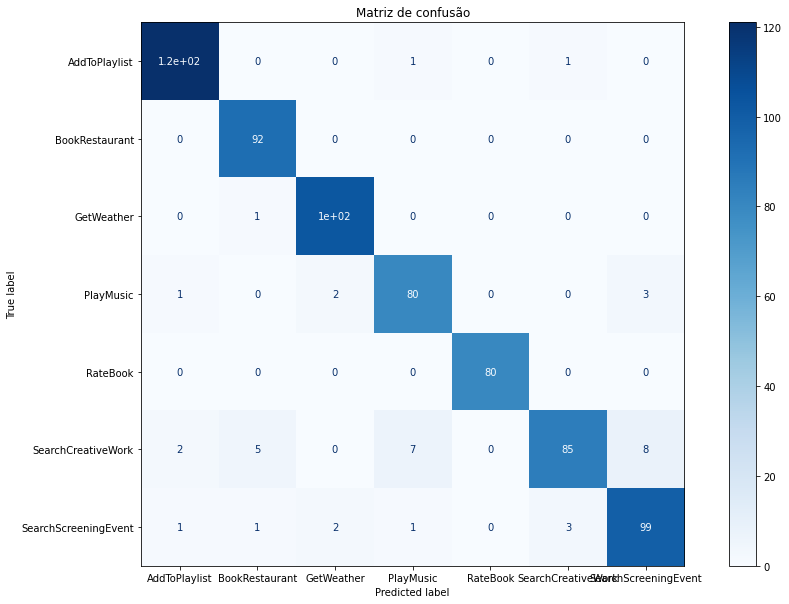

In [25]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# Gerar matriz de confusão

fig, ax = plt.subplots(figsize=(16, 10))
matrix = plot_confusion_matrix(Knn, dataset_test_vectors, dataset_teste['intent'],
                                 cmap=plt.cm.Blues,ax=ax)
plt.title('Matriz de confusão')
plt.show(matrix)
plt.show()



In [26]:
# Vamos obter os resultados das métricas F1-score e um relatório mais completo de avaliação
from sklearn.metrics import classification_report

print(classification_report( dataset_teste['intent'], classes_preditas))


                      precision    recall  f1-score   support

       AddToPlaylist       0.97      0.98      0.98       123
      BookRestaurant       0.93      1.00      0.96        92
          GetWeather       0.96      0.99      0.98       104
           PlayMusic       0.90      0.93      0.91        86
            RateBook       1.00      1.00      1.00        80
  SearchCreativeWork       0.96      0.79      0.87       107
SearchScreeningEvent       0.90      0.93      0.91       107

            accuracy                           0.94       699
           macro avg       0.94      0.95      0.94       699
        weighted avg       0.94      0.94      0.94       699

